## Setup

In [37]:
# RUN SETUP.SH BEFORE RUNNING THIS IPYNB

import pandas as pd
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB # Naive Bayes Classifier
from sklearn.linear_model import LogisticRegression # Logistic Regression Classifier
from sklearn.neural_network import MLPClassifier # Multi Layer Perceptron, simple Neural Network
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import ADASYN, RandomOverSampler
from scipy.sparse import hstack, csr_matrix
import spacy
import re
import numpy as np
from spacytextblob.spacytextblob import SpacyTextBlob
import matplotlib.pyplot as plt

In [38]:
SEED = 42 # seed random state for comparison, testing
PARTITION_SIZE = 500 # Adjust lower if potato PC and higher if gaming rig or want results closer to actual
enable_all_data = True # SET TO FALSE IF PREPROCESSING TAKES A LONG TIME (True = test on PARTITION_SIZE training and PARTITION_SIZE testing samples)

## Pre-processing

In [39]:
### Jian Hui start

In [40]:
df = pd.read_csv('raw_data/fulltrain.csv', header=None, index_col = False)
df.head()

,0,1
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [41]:
df = df if enable_all_data else df.sample(n=PARTITION_SIZE, random_state=SEED)

X_train = df.iloc[:, 1] 
y_train = df.iloc[:, 0]
X_train_unprocessed = X_train
print(X_train)
print(y_train)

print(len(X_train))
print(len(y_train))

y_train.value_counts()

0        A little less than a decade ago, hockey fans w...
1        The writers of the HBO series The Sopranos too...
2        Despite claims from the TV news outlet to offe...
3        After receiving 'subpar' service and experienc...
4        After watching his beloved Seattle Mariners pr...
                               ...                        
48849    The ruling Kuomintang (KMT) has claimed owners...
48850    The Taipei city government has encouraged the ...
48851    President Ma Ying-jeou said Friday that a park...
48852    The families of the four people who were kille...
48853    The Ministry of Finance will make public on Sa...
Name: 1, Length: 48854, dtype: object
0        1
1        1
2        1
3        1
4        1
        ..
48849    4
48850    4
48851    4
48852    4
48853    4
Name: 0, Length: 48854, dtype: int64
48854
48854


0
3    17870
1    14047
4     9995
2     6942
Name: count, dtype: int64

In [42]:
# Processing data: tokenize the text for NLP Machine Learning
# Lemmatization, Case-folding (lowercase), Stopword removal, Punctuation removal
# Eric
personal_pronouns = ["i", "me", "mine", "my", "myself", "our", "ours", "we", \
                     "their", "you", "your", "he", "she", "it", "its", "we", "they", "me", \
                     "him", "her", "us", "them", "his", "hers", "herself", \
                        "himself", "itself", "themselves", "ourselves", "yourself", "yourselves"]
spacy_preprocess_model = spacy.load("en_core_web_lg")
spacy_preprocess_model.Defaults.stop_words -= set(personal_pronouns)

# def preprocess(sentence):
#     '''
#     Preprocessing strategies:
#     1) Tokenization
#     2) Punctuation removal
#     3) Stopword removal
#     4) Lemmatization
#     5) Lowercase
#     '''
#     tokens = spacy_preprocess_model(sentence)
#     ls_sentence = [token.lemma_.lower() for token in tokens if not (token.is_punct and token not in ["!", "?"]) and not token.is_stop]
#     return ls_sentence

In [43]:
# Processing data: tokenize the text for NLP Machine Learning
# Case-folding (lowercase), Stopword removal, Punctuation removal

def preprocess(sentence):
    '''
    Preprocessing strategies:
    1) Tokenization
    2) Punctuation removal
    3) Stopword removal
    4) Lowercase
    '''
    tokens = spacy_preprocess_model(sentence)
    ls_sentence = [token.text.lower() for token in tokens if not (token.is_punct and token not in ["!", "?"]) and not token.is_stop]
    return ls_sentence

In [44]:
# Processing data: tokenize the text for NLP Machine Learning
# Case-folding (lowercase), Punctuation removal

# def preprocess(sentence):
#     '''
#     Preprocessing strategies:
#     1) Tokenization
#     2) Punctuation removal
#     3) Lowercase
#     '''
#     tokens = spacy_preprocess_model(sentence)
#     ls_sentence = [token.text.lower() for token in tokens if not (token.is_punct and token not in ["!", "?"])]
#     return ls_sentence

In [45]:
# Processing data: tokenize the text for NLP Machine Learning
# pos (TAG), Punctuation removal

# def preprocess(sentence):
#     '''
#     Preprocessing strategies:
#     1) Tokenization
#     2) Punctuation removal
#     3) POS tag
#     '''
#     tokens = spacy_preprocess_model(sentence)
#     ls_sentence = [token.tag_ for token in tokens if not (token.is_punct and token not in ["!", "?"])]
#     return ls_sentence

In [46]:
# To be used by features for feature extraction:
# X_train_ls = X_train.apply(preprocess)
# X_train_sentence = X_train_ls.apply(lambda sentence: ' '.join(sentence))

# X_train_ls = X_train
# X_train_sentence = X_train_ls

### Save and load preprocessed data

In [47]:
# X_train_sentence.head()

In [48]:
# Save pre-processed data
# compression_opts = dict(method='zip', archive_name='strip_punct_stop_lower.csv')
# X_train_sentence.to_csv('strip_punct_stop_lower.zip', index=False, compression=compression_opts)

In [49]:
# quickload pre-processed data
# replace 'raw_data/*.csv' with .csv file containing preprocessed data
X_train = pd.read_csv('strip_punct_stop_lower.csv', index_col=False).iloc[:, 0]
X_train.head()

# Reload constants if preprocessing cells are not executed
personal_pronouns = ["i", "me", "mine", "my", "myself", "our", "ours", "we", \
                     "their", "you", "your", "he", "she", "it", "its", "we", "they", "me", \
                     "him", "her", "us", "them", "his", "hers", "herself", \
                        "himself", "itself", "themselves", "ourselves", "yourself", "yourselves"]
spacy_model = spacy.load("en_core_web_lg")
spacy_model.Defaults.stop_words -= set(personal_pronouns)
spacy_model.add_pipe('spacytextblob')

### Train-Validation Split

In [50]:
X_train_unprocessed, _, _, _ = train_test_split(X_train_unprocessed, y_train, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

### Feature analysis

In [51]:
def count_analysis(X, y):
    unique_y = np.unique(y)
    fig, axs = plt.subplots(len(unique_y), 1, figsize=(8, len(unique_y) * 4))
    for i in unique_y:
        indices = np.where(y == i)[0]
        counts_i = X[indices]
        unique_vals, counts = np.unique(counts_i, return_counts=True)
        axs[i-1].scatter(unique_vals, counts)
        axs[i-1].set_xlabel('X: ' + str(i))
        axs[i-1].set_ylabel('y: ' + str(i))
        axs[i-1].set_title('X against y: ' + str(i))

    plt.tight_layout()
    plt.show()

### Feature Engineering

In [52]:
# Feature set:
# 1) TF-IDF
tfidf_vectorizer = CountVectorizer(ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [53]:
# 2) Sentiment analysis
def sentiment_analysis(sentence):
    doc = spacy_model(sentence)
    return doc._.blob.polarity

X_train_sent_ana = X_train_unprocessed.apply(sentiment_analysis).to_numpy().reshape(-1, 1)

In [55]:
# Save sentiment analysis output
pd_sent_ana = pd.DataFrame(X_train_sent_ana, columns=["Sentiment"])
compression_opts = dict(method='zip', archive_name='sent_ana.csv')
pd_sent_ana.to_csv('sent_ana.zip', index=False, compression=compression_opts)

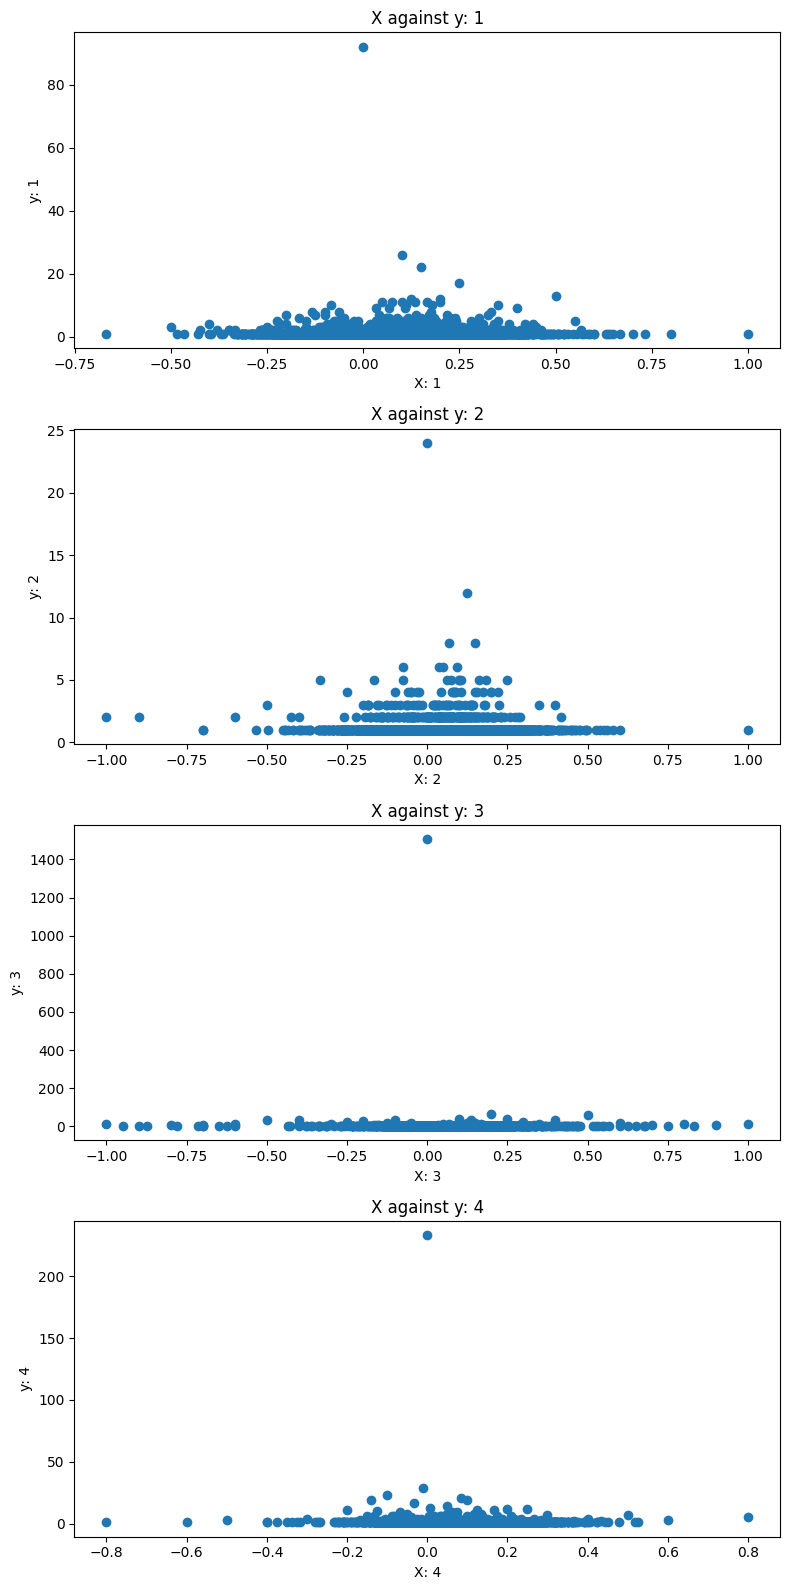

In [56]:
## Analysis of sentiment feature
count_analysis(X_train_sent_ana, y_train)

In [57]:
# 3) Subjectivity analysis 
def subjectivity_analysis(sentence):
    doc = spacy_model(sentence)
    return doc._.blob.subjectivity

X_train_subj_ana = X_train_unprocessed.apply(subjectivity_analysis).to_numpy().reshape(-1, 1)

## Analysis of subjectivity feature
count_analysis(X_train_subj_ana, y_train)

In [ ]:
# Save sentiment analysis output
pd_subj_ana = pd.DataFrame(X_train_subj_ana, columns=["Subjectivity"])
compression_opts = dict(method='zip', archive_name='subj_ana.csv')
pd_subj_ana.to_csv('subj_ana.zip', index=False, compression=compression_opts)

In [ ]:
# 4) Number of exclamation and question marks (pre-analyze first)
def count_exclamation_marks(sentence):
    return len(re.findall(r'\!', sentence))

def count_question_marks(sentence):
    return len(re.findall(r'\?', sentence))

X_train_count_ex = X_train.apply(count_exclamation_marks).to_numpy().reshape(-1, 1)
X_train_count_qn = X_train.apply(count_question_marks).to_numpy().reshape(-1, 1)

In [ ]:
# 5) Summation of word2vec on top k words tf-idf per sentence
k = 5
tfidf_vectorizer_word2vec = TfidfVectorizer(sublinear_tf=True)
tfidf_word2vec = tfidf_vectorizer_word2vec.fit_transform(X_train)
non_zero_counts = tfidf_word2vec.getnnz(axis=1)

def word2vec_select_k_best_sum(matrix):
    res = None
    for row in range(matrix.shape[0]):
        # Get indexes of words
        num_words = min(k, non_zero_counts[row])
        row_val_idxs = matrix[row].indices
        top_k_idx = np.argpartition(matrix[row].data, -num_words)[-num_words:]
        indexes = row_val_idxs[top_k_idx]
        
        # Get words
        words = tfidf_vectorizer_word2vec.get_feature_names_out()[indexes]

        # Get summation of word vectors
        summation_vector = np.sum(np.array([spacy_model(word).vector for word in words]), axis=0)
        if res is None:
            res = np.zeros([matrix.shape[0], summation_vector.shape[0]])
        res[row] = summation_vector

    return res

X_train_word2vec = word2vec_select_k_best_sum(tfidf_word2vec)


In [ ]:
# 6) Number of personal pronouns
def count_personal_pronouns(sentence):
    counter = 0
    sentence_ls = sentence.split()
    for token in sentence_ls:
        if token in personal_pronouns:
            counter += 1
    return counter

X_train_count_pp = X_train.apply(count_personal_pronouns).to_numpy().reshape(-1, 1)

In [ ]:
# 7) 

# Model: LSTM? Random forest, SVM

In [ ]:
# Consolidation of feature sets into single vector:
# Eric
# print(X_train_tfidf.shape)
# print(X_train_sent_ana.shape)
# print(X_train_subj_ana.shape)
# print(X_train_count_ex.shape)
# print(X_train_count_qn.shape)
# print(X_train_word2vec.shape)
# print(X_train_count_pp.shape)
X_train = hstack([X_train_tfidf, X_train_sent_ana, X_train_subj_ana, X_train_count_ex, X_train_count_qn, X_train_word2vec, X_train_count_pp])
# X_train = hstack([X_train_tfidf, X_train_count_ex, X_train_count_qn, X_train_count_pp])

### Oversampling

In [ ]:
# RandomOverSampler
ros = RandomOverSampler(random_state=SEED)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [ ]:
# ADASYN
# ada = ADASYN(random_state=SEED)
# X_train, y_train = ada.fit_resample(X_train, y_train)

In [ ]:
# SMOTEENN

## Models

### Naive Bayes Model [MultinomialNB]

In [ ]:
# model = MultinomialNB().fit(X_train, y_train) # fit model

### Logistic Regression Model [LogisticRegression]

In [ ]:
model = LogisticRegression(solver = 'saga', max_iter=10000).fit(X_train, y_train) # train the model

## Validation

In [ ]:
# Apply feature engineering on X_val
val_tfidf_word2vec = tfidf_vectorizer_word2vec.transform(X_val)
non_zero_counts = val_tfidf_word2vec.getnnz(axis=1)

X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_val_sent_ana = X_val.apply(sentiment_analysis).to_numpy().reshape(-1, 1)
X_val_subj_ana = X_val.apply(subjectivity_analysis).to_numpy().reshape(-1, 1)
X_val_count_ex = X_val.apply(count_exclamation_marks).to_numpy().reshape(-1, 1)
X_val_count_qn = X_val.apply(count_question_marks).to_numpy().reshape(-1, 1)
X_val_word2vec = word2vec_select_k_best_sum(val_tfidf_word2vec)
X_val_count_pp = X_val.apply(count_personal_pronouns).to_numpy().reshape(-1, 1)

In [ ]:
# Consolidation of feature sets:
X_val_final = hstack([X_val_tfidf, X_val_sent_ana, X_val_subj_ana, X_val_count_ex, X_val_count_qn, X_val_word2vec, X_val_count_pp])

In [ ]:
# obtain predictions on validation data
y_val_predicted = model.predict(X_val_final)

# evaluate model training metrics with macro f1 score
f1_score(y_val, y_val_predicted, average='macro')

0.6320210170765249

## Test Data

In [ ]:
# TEST DATA 
test_df = pd.read_csv('raw_data/balancedtest.csv', index_col = False)
test_df = test_df if enable_all_data else test_df.sample(PARTITION_SIZE)

In [ ]:
X_test = test_df.iloc[:, 1]
y_test = test_df.iloc[:, 0]

# print(X_test.head())
# print(y_test.head())

In [ ]:
# Preprocess test data to match steps on training data
X_test_ls = X_test.apply(preprocess)
X_test_sentence = X_test_ls.apply(lambda sentence: ' '.join(sentence))

X_test = X_test_sentence

### Feature Engineering (Test Data)

In [ ]:
test_tfidf_word2vec = tfidf_vectorizer_word2vec.transform(X_test)
non_zero_counts = test_tfidf_word2vec.getnnz(axis=1)

X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_test_sent_ana = X_test.apply(sentiment_analysis).to_numpy().reshape(-1, 1)
X_test_subj_ana = X_test.apply(subjectivity_analysis).to_numpy().reshape(-1, 1)
X_test_count_ex = X_test.apply(count_exclamation_marks).to_numpy().reshape(-1, 1)
X_test_count_qn = X_test.apply(count_question_marks).to_numpy().reshape(-1, 1)
X_test_word2vec = word2vec_select_k_best_sum(test_tfidf_word2vec)
X_test_count_pp = X_test.apply(count_personal_pronouns).to_numpy().reshape(-1, 1)

In [ ]:
# Consolidation of feature transformations into single vector
# Eric
X_test_final = hstack([X_test_tfidf, X_test_sent_ana, X_test_subj_ana, X_test_count_ex, X_test_count_qn, X_test_word2vec, X_test_count_pp])

In [ ]:
# obtain predictions on test data
y_pred = model.predict(X_test_final)

# evaluate model training metrics with macro f1 score
f1_score(y_test, y_pred, average='macro')

0.4723953270193005

In [ ]:
# do prediction on training data
y_train_predicted = model.predict(X_train)

# obtain training f1 score
f1_score(y_train, y_train_predicted, average='macro') # TODO this tests the model on its already trained set...

0.6512006559989986

In [ ]:
# obtain predictions on test data
y_pred = model.predict(X_test)

# obtain test f1 score
f1_score(y_test, y_pred, average= 'macro')

ValueError: could not convert string to float: '  football insiders calling unexpectedly severe punishment national football league sentenced new england patriots quarterback tom brady year new york jets his role called deflategate scandal punishment drew howls protest patriots fans management calling harshest league history n.f.l. commissioner roger goodell defended decision necessary deterrent need send message league zero tolerance cheating goodell said believe year playing quarterback jets sends message loud clear brady reportedly state shock heard news his punishment later met reporters hastily called press conference frequently verge tears going fight decision fibre my brady said america nt force person play jets sports bar manhattan reaction impending arrival jets longtime nemesis muted jets fan observed look bradys dick nt deserve'

In [ ]:
### Hyper Parameter tuning with GridSearchCV()

In [ ]:
### Jian Hui end

In [ ]:
### <Group Member's name> start

In [ ]:
# Group member's code here

In [ ]:
### <Group Member's name> end